# compute spectra on mitgcm outputs

https://github.com/pydata/xarray/pull/924

https://github.com/pydata/xarray/issues/1603



---

In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

import xrft

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
dmethod = 1
#
if dmethod == 1:
    from dask.distributed import Client
    scheduler = os.getenv('DATAWORK')+'/dask/scheduler.json'
    client = Client(scheduler_file=scheduler)
elif dmethod == 2:
    from dask_jobqueue import PBSCluster
    # folder where data is spilled when RAM is filled up
    local_dir = os.getenv('TMPDIR')
    #
    cluster = PBSCluster(queue='mpi_1', local_directory=local_dir, interface='ib0', walltime='24:00:00',
                         threads=14, processes=2, memory='50GB', resource_spec='select=1:ncpus=28:mem=100g', 
                         death_timeout=100)
    w = cluster.start_workers(40)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# you need to wait for workers to spin up
if dmethod == 2:
    cluster.scheduler

In [4]:
# get dask handles and check dask server status
if dmethod == 2:
    from dask.distributed import Client
    client = Client(cluster)

In [5]:
client

Client Scheduler: tcp://10.148.0.148:8786 Dashboard: http://10.148.0.148:8787/status,Cluster Workers: 15 Cores: 210 Memory: 1500.00 GB


---

# 0: variable select and path


In [6]:
v = 'Eta'

## open files, nc files
#ncdata_dir = datawork+'/mit_nc_t/'
ncdata_dir = scratch+'/mit_nc/'
ncdata_dir = '/home1/scratch/xyu/mit_nc/'

# dir where spectra are stored
# E_dir = '/home/datawork-lops-osi/aponte/mit_spec/'
E_dir = '/home1/scratch/xyu/mit_spec/zavg_Eta/'

print(ncdata_dir)
print(E_dir)


/home1/scratch/xyu/mit_nc/
/home1/scratch/xyu/mit_spec/zavg_Eta/


--- 

# 1: One face 

## load data

In [7]:
face = 1

# search for right files, for example: Eta_f01_t*.nc
filenames = sorted(glob(ncdata_dir+v+'_f%02d_t*.nc' %(face)))

In [8]:
print('Number of files available: %d' %len(filenames))
#filenames = filenames[:2] # tmp
print('Number of files processed: %d' %len(filenames))

grid = xr.open_dataset('/home1/scratch/xyu/mit_grid_t.nc')
grid = grid.isel(face=face).drop(['XG','YG','i_g','j_g','k','k_u','k_l','k_p1'])
print(grid)

Number of files available: 34
Number of files processed: 34
<xarray.Dataset>
Dimensions:  (i: 4320, j: 4320)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    face     int64 1
    XC       (i, j) float32 ...
    YC       (i, j) float32 ...
    rA       (i, j) float32 ...
    Depth    (i, j) float32 ...
Data variables:
    *empty*
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(llc_method='smallchunks...


In [9]:
#%time ds = xr.open_mfdataset(filenames, concat_dim='time', compat='equals')
%time ds = xr.open_mfdataset(filenames, chunks={'i':10, 'j':432}, concat_dim='time', compat='equals')

print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

CPU times: user 1.22 s, sys: 260 ms, total: 1.48 s
Wall time: 6.81 s
<xarray.Dataset>
Dimensions:  (i: 4320, j: 4320, time: 8160)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    face     int64 1
  * time     (time) float64 2.592e+05 2.628e+05 2.664e+05 2.7e+05 2.736e+05 ...
Data variables:
    Eta      (i, j, time) float32 dask.array<shape=(4320, 4320, 8160), chunksize=(10, 432, 240)>

 data size: 609.1 GB


In [10]:
chunks={'time': len(ds['time'])}
%time ds = ds.chunk(chunks)
print(ds)

CPU times: user 720 ms, sys: 12 ms, total: 732 ms
Wall time: 739 ms
<xarray.Dataset>
Dimensions:  (i: 4320, j: 4320, time: 8160)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    face     int64 1
  * time     (time) float64 2.592e+05 2.628e+05 2.664e+05 2.7e+05 2.736e+05 ...
Data variables:
    Eta      (i, j, time) float32 dask.array<shape=(4320, 4320, 8160), chunksize=(10, 432, 8160)>


In [11]:
%time eta = ds['Eta'].persist()

CPU times: user 33.8 s, sys: 628 ms, total: 34.4 s
Wall time: 34.4 s



## compute and store spectra


In [2]:
v_fft = xrft.dft(eta.fillna(0.), dim=['time'], shift=False, detrend='linear')
E = (v_fft*v_fft.conj()).where(v_fft!=0., drop=False)
E = E.astype('f8').rename('E_eta')
E = xr.merge([E, grid])
print(E)

NameError: name 'eta' is not defined

In [13]:
file_E = '/home1/scratch/xyu／mit_spec/E_f00.nc'
print(file_E)

/home1/scratch/xyu／mit_spec/E_f00.nc


In [14]:
#dst = ds.transpose('face', 'i', 'j', 'i_g', 'j_g', 'k', 'k_l', 'k_p1', 'k_u')



E.to_netcdf(file_E,mode='w')
# should transpose?

PermissionError: [Errno 13] Permission denied: b'/home1/scratch/xyu\xef\xbc\x8fmit_spec/E_f00.nc'

## zonally average spectra

In [16]:
def fmap(v1, v2, b1, b2):
        ''' This function provides the index of (v1,v2) coupled value position
        in the 2D histogram array
        '''
        #
        i1 = np.maximum(np.rint((v1-b1['min'])/b1['d'])+1,0)
        i1 = np.minimum(i1,b1['imax'])
        #
        i2 = np.maximum(np.rint((v2-b2['min'])/b2['d'])+1,0)
        i2 = np.minimum(i2,b2['imax'])
        return i1+i2*(b1['imax']+1)

In [17]:
file_E = E_dir+'E_f%02d.nc'%face    
ds = xr.open_dataset(file_E, chunks={'i': 1, 'j': 2160})

#
f = ds['freq_time']
fv = f.values
# lat
vb1 = {'min': -60.,'max': 60., 'd': 1.}
# frequency
vb2 = {'min': fv.min(), 'max': fv.max(), 'd': fv[1]-fv[0]}
#
vb1['imax'] = np.int(np.rint((vb1['max']-vb1['min'])/vb1['d']))+1
vb2['imax'] = np.int(np.rint((vb2['max']-vb2['min'])/vb2['d']))+1
#
lat_edges = np.arange(vb1['min'], vb1['max']+vb1['d']*.1, vb1['d'])
lat_center = (lat_edges[:-1]+lat_edges[1:])*.5
f_edges = np.arange(vb2['min'], vb2['max']+vb2['d']*.1, vb2['d'])
f_center = (f_edges[:-1]+f_edges[1:])*.5

# broadcast coordinates
lat = ds['YC']    
lat2 = (lat + 0.*ds.E).fillna(-100.)
f2 = lat2*0. + f
dA = ds.rA + 0.*f2
EdA = ds.E.fillna(0.)*dA

# apply get_index to v1 and v2 arrays
i = dask.array.map_blocks(fmap, lat2.data, f2.data, vb1, vb2,  dtype='float')

# compute histogram of linear indices
h, lbins = dask.array.histogram(i, bins=np.arange(-.5,(vb1['imax']+1)*(vb2['imax']+1)+0.5,1.), \
                                weights=EdA.data)
hnorm, lbins = dask.array.histogram(i, bins=np.arange(-.5,(vb1['imax']+1)*(vb2['imax']+1)+0.5,1.), \
                                weights=dA.data)

# normalize and reshape
H = h.compute()
Hnorm = hnorm.compute()
H = H/Hnorm
H = H.reshape((vb1['imax']+1,vb2['imax']+1), order='F')
Hnorm = Hnorm.reshape((vb1['imax']+1,vb2['imax']+1), order='F')

# put H back into an xarray
ds_zavg = xr.Dataset({'E': (['lat', 'freq_time'],  H[1:-1,1:-1]), \
                      'A': (['lat'],  Hnorm[1:-1,1])}, \
                     coords={'lat': lat_center, 'freq_time': f_center})
ds_zavg = ds_zavg.sortby('freq_time')
ds_zavg.to_netcdf(E_dir+'E_zavg_f%02d.nc'%face, mode='w')
    

FileNotFoundError: [Errno 2] No such file or directory: b'/home1/scratch/xyu/mit_spec/E_f01.nc'

In [ ]:
# plot

# ds_zavg = xr.open_dataset(E_dir+'E_zavg_f%02d.nc'%face)
np.log10(ds_zavg.E).plot()

---

# 2: All faces

## compute and store spectra for all faces

In [ ]:
# same but loop over faces now
E_dir = '/home1/scratch/xyu/mit_spec/'


# number of fies to load for each face (1 file = 10 days)
Nf = 5

mgrid = xr.open_dataset('/home1/scratch/xyu/mit_grid_t.nc')
mgrid = mgrid.drop(['XG','YG','i_g','j_g','k','k_u','k_l','k_p1'])

for face in range(13):

    # could add a test if files exists
    
    filenames = sorted(glob(ncdata_dir+v+'_f%02d_t*.nc' %(face)))
    filenames = filenames[:Nf]

    grid = mgrid.isel(face=face)
    
    ds = xr.open_mfdataset(filenames, chunks={'i':10, 'j':432}, concat_dim='time', compat='equals')
    #ds = ds.isel(time=slice(0,3000))
    
    chunks={'time': len(ds['time'])}
    ds = ds.chunk(chunks)

    eta = ds[v]
    
    v_fft = xrft.dft(eta.fillna(0.), dim=['time'], shift=False, detrend='linear')
    E = (v_fft*v_fft.conj()).where(v_fft!=0., drop=False)
    E = E.astype('f8').rename('E')
    E = xr.merge([E, grid])

    #file_E = scratch+'/mit_spec/E_f%02d.nc'%face
    file_E = E_dir+'E_Eta_f%02d.nc'%face    
    E.to_netcdf(file_E, mode='w')
    
    print('face %d done'%face )


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/worker.py:742: UserWarning: Large object of size 5.41 MB detected in task graph: 
  ("('astype-42c4548e8fbe8ef7ab5b8d583a005d8b', 0, 0 ... feea>]), False)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s))


## zonally average spectra

Faces are processed independantly, this alleviate the computational burden on the scheduler (large task graph issue)


In [ ]:
def fmap(v1, v2, b1, b2):
        ''' This function provides the index of (v1,v2) coupled value position
        in the 2D histogram array
        '''
        #
        i1 = np.maximum(np.rint((v1-b1['min'])/b1['d'])+1,0)
        i1 = np.minimum(i1,b1['imax'])
        #
        i2 = np.maximum(np.rint((v2-b2['min'])/b2['d'])+1,0)
        i2 = np.minimum(i2,b2['imax'])
        return i1+i2*(b1['imax']+1)

idum = 0
for face in range(13):

    file_E = E_dir+'E_Eta_f%02d.nc'%face    
    ds = xr.open_dataset(file_E, chunks={'i': 1, 'j': 2160})

    #
    if idum == 0:
        f = ds['freq_time']
        fv = f.values
        # lat
        vb1 = {'min': -60.,'max': 60., 'd': 1.}
        # frequency
        vb2 = {'min': fv.min(), 'max': fv.max(), 'd': fv[1]-fv[0]}
        #
        vb1['imax'] = np.int(np.rint((vb1['max']-vb1['min'])/vb1['d']))+1
        vb2['imax'] = np.int(np.rint((vb2['max']-vb2['min'])/vb2['d']))+1
        #
        lat_edges = np.arange(vb1['min'], vb1['max']+vb1['d']*.1, vb1['d'])
        lat_center = (lat_edges[:-1]+lat_edges[1:])*.5
        f_edges = np.arange(vb2['min'], vb2['max']+vb2['d']*.1, vb2['d'])
        f_center = (f_edges[:-1]+f_edges[1:])*.5
        idum +=1 

    # broadcast coordinates
    lat = ds['YC']    
    lat2 = (lat + 0.*ds.E).fillna(-100.)
    f2 = lat2*0. + f
    dA = ds.rA + 0.*f2
    EdA = ds.E.fillna(0.)*dA

    # apply get_index to v1 and v2 arrays
    i = dask.array.map_blocks(fmap, lat2.data, f2.data, vb1, vb2,  dtype='float')
    #print(i)

    # compute histogram of linear indices
    h, lbins = dask.array.histogram(i, bins=np.arange(-.5,(vb1['imax']+1)*(vb2['imax']+1)+0.5,1.), \
                                    weights=EdA.data)
    hnorm, lbins = dask.array.histogram(i, bins=np.arange(-.5,(vb1['imax']+1)*(vb2['imax']+1)+0.5,1.), \
                                    weights=dA.data)

    # normalize and reshape
    H = h.compute()
    Hnorm = hnorm.compute()
    H = H/Hnorm
    H = H.reshape((vb1['imax']+1,vb2['imax']+1), order='F')
    Hnorm = Hnorm.reshape((vb1['imax']+1,vb2['imax']+1), order='F')

    # put H back into an xarray
    ds_zavg = xr.Dataset({'E': (['lat', 'freq_time'],  H[1:-1,1:-1]), \
                          'A': (['lat'],  Hnorm[1:-1,1])}, \
                         coords={'lat': lat_center, 'freq_time': f_center})
    ds_zavg = ds_zavg.sortby('freq_time')
    ds_zavg.to_netcdf(E_dir+'E_Eta_zavg_f%02d.nc'%face, mode='w')
    

## load and plot zonally averaged spectra

In [7]:
filenames = sorted(glob(E_dir+'E_Eta_zavg_f*.nc'))
print(E_dir)
%time ds = xr.open_mfdataset(filenames, concat_dim='face', compat='equals')


/home1/scratch/xyu/mit_spec/zavg_Eta/
CPU times: user 128 ms, sys: 28 ms, total: 156 ms
Wall time: 1.39 s


In [8]:
E = (ds.E*ds.A).sum(dim='face') / ds.A.sum(dim='face')
print(E)

<xarray.DataArray (lat: 120, freq_time: 1199)>
dask.array<shape=(120, 1199), dtype=float64, chunksize=(120, 1199)>
Coordinates:
  * lat        (lat) float64 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5 -53.5 -52.5 ...
  * freq_time  (freq_time) float64 -0.0001388 -0.0001385 -0.0001383 ...


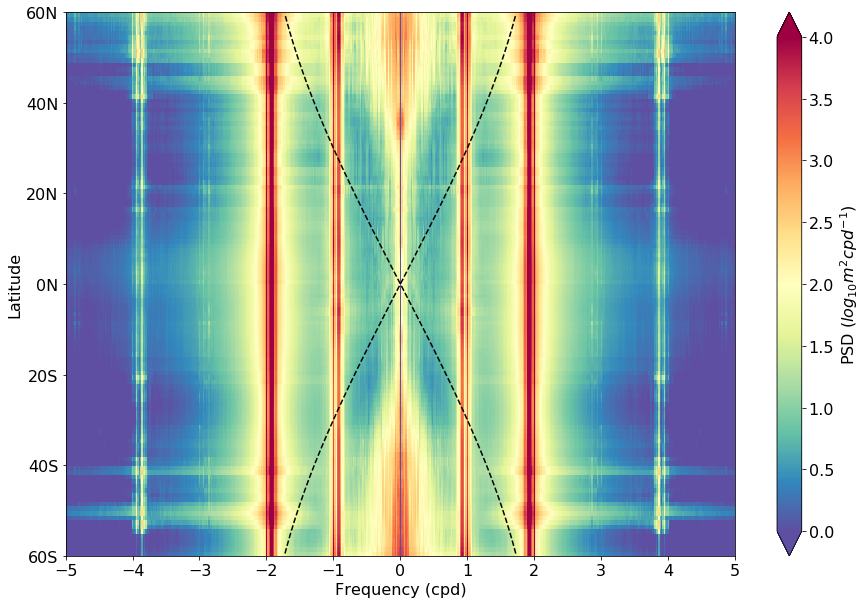

In [11]:

plt.figure(figsize=(15,10))
ax = plt.subplot(1,1,1)

E = E.assign_coords(freq_cpd=E.freq_time * 86400.)

cax = np.log10(E).plot.pcolormesh(ax=ax, vmin=0, vmax=4, x='freq_cpd', y='lat', cmap = 'Spectral_r', add_colorbar = False)

# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=16)
cbar.set_label('PSD ($log_{10} m^2 cpd^{-1})$', fontsize=16)

# x,y ticks
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['60S','40S','20S','0N','20N','40N','60N'])

ax.set_ylabel('Latitude',fontsize=16)
ax.set_xlabel('Frequency (cpd)',fontsize=16)
ax.tick_params(labelsize=16)

# add coriolis frequency
f = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E.lat))
ax.plot(f*86400./2./np.pi,f.lat,'k--')
ax.plot(-f*86400./2./np.pi,f.lat,'k--')

---

In [12]:
client.restart()

Client Scheduler: tcp://10.148.0.148:8786 Dashboard: http://10.148.0.148:8787/status,Cluster Workers: 15 Cores: 210 Memory: 1500.00 GB
